In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 7.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 69 kB 9.5 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=cce72e8af59424df5d7c093c882f9c6513a889aad68ca5bdb798133724b51107
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=88dd975019859d6c4c3b7568200c5c44374590804180d66a672ad34824814f22
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built pycuda pytools


In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Thread  synchronization and intercommunication

## Using the __syncthreads() device function

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    #define _WIDTH (blockDim.x * gridDim.x)
    #define _HEIGHT (blockDim.y * gridDim.y)

    #define _XM(x) ((x + _WIDTH) % _WIDTH)
    #define _YM(y) ((y + _HEIGHT) % _HEIGHT)

    #define  _INDEX(x,y) (_XM(x) + _YM(y) * _WIDTH)

    __device__ int nbrs(int x, int y, int *in)
    {
        return (in[_INDEX(x-1,y+1)] + in[_INDEX(x-1,y)] + in[_INDEX(x-1,y-1)]\
              + in[_INDEX(x  ,y+1)] + in[_INDEX(x  ,y)] + in[_INDEX(x  ,y-1)]\
              + in[_INDEX(x+1,y+1)] + in[_INDEX(x+1,y)] + in[_INDEX(x+1,y-1)]);
    }

    __global__ void conway_ker(int *lattice, int iters)
    {
        int x = _X;
        int y = _Y;

        for (int i = 0; i < iters; i++)
        {
            int n = nbrs(x, y, lattice);
            int cell_value;

            if (lattice[_INDEX(x,y)] == 1)
            switch(n)
            {
                // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
                case 2:
                case 3: cell_value = 1;
                break;
                default: cell_value = 0;
            }

            else if (lattice[_INDEX(x,y)] == 0)
            switch(n)
            {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                break;
                default: cell_value = 0;
            }
            __syncthreads();
            lattice[_INDEX(x,y)] = cell_value;
            __syncthreads();
        }
    }
    """
)

conway_ker = ker.get_function("conway_ker")

8.01e-05


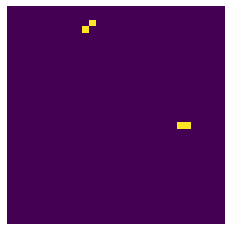

In [ ]:
if __name__ == "__main__":
    # set lattice size
    N = 32
    lattice = np.int32(np.random.choice([0,1], N*N, p=[0.25,0.75]).reshape(N,N))

    lattice_gpu = gpuarray.to_gpu(lattice)

    t1 = time()
    conway_ker(lattice_gpu, np.int32(1000000), grid=(1,1,1), block=(32,32,1))
    t2 = time()
    
    fig = plt.figure(1)
    plt.imshow(lattice_gpu.get())
    plt.axis("off")

    print(f"{round(t2-t1, 7)}")

# Using shared memory

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    #define _WIDTH (blockDim.x * gridDim.x)
    #define _HEIGHT (blockDim.y * gridDim.y)

    #define _XM(x) ((x + _WIDTH) % _WIDTH)
    #define _YM(y) ((y + _HEIGHT) % _HEIGHT)

    #define  _INDEX(x,y) (_XM(x) + _YM(y) * _WIDTH)

    __device__ int nbrs(int x, int y, int *in)
    {
        return (in[_INDEX(x-1,y+1)] + in[_INDEX(x-1,y)] + in[_INDEX(x-1,y-1)]\
              + in[_INDEX(x  ,y+1)] + in[_INDEX(x  ,y)] + in[_INDEX(x  ,y-1)]\
              + in[_INDEX(x+1,y+1)] + in[_INDEX(x+1,y)] + in[_INDEX(x+1,y-1)]);
    }

    __global__ void conway_ker_shared(int *p_lattice, int iters)
    {
        int x = _X;
        int y = _Y;
        __shared__ int lattice[32*32];
        
        lattice[_INDEX(x,y)] = p_lattice[_INDEX(x,y)];
        __syncthreads();

        for (int i = 0; i < iters; i++)
        {
            int n = nbrs(x, y, lattice);
            int cell_value;

            if (lattice[_INDEX(x,y)] == 1)
            switch(n)
            {
                // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
                case 2:
                case 3: cell_value = 1;
                break;
                default: cell_value = 0;
            }

            else if (lattice[_INDEX(x,y)] == 0)
            switch(n)
            {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                break;
                default: cell_value = 0;
            }
            __syncthreads();
            lattice[_INDEX(x,y)] = cell_value;
            __syncthreads();
        }
        p_lattice[_INDEX(x,y)] = lattice[_INDEX(x,y)];
        __syncthreads();
    }
    """
)

conway_ker_shared = ker.get_function("conway_ker_shared")

8.08e-05


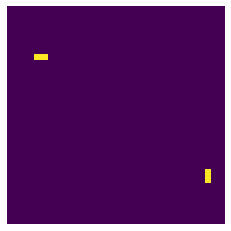

In [ ]:
if __name__ == "__main__":
    # set lattice size
    N = 32
    lattice = np.int32(np.random.choice([0,1], N*N, p=[0.25,0.75]).reshape(N,N))

    lattice_gpu = gpuarray.to_gpu(lattice)
    
    t1 = time()
    conway_ker_shared(lattice_gpu, np.int32(1000000), grid=(1,1,1), block=(32,32,1))
    t2 = time()

    fig = plt.figure(1)
    plt.imshow(lattice_gpu.get())
    plt.axis("off")

    print(f"{round(t2-t1, 7)}")

# The parallel prefix algorithm

## The naive parallel prefix algorithm

input: 
$x_0, ..., x_{n-1}$<br>

initialize:<br>
for k = 0 to n-1:<br>
$
\qquad y_k := x_k
$

begin:<br>
parfor i = 0 to n-1:<br>
$\qquad$for j = 0 to $log_2(n)$:<br>
$\qquad\qquad$if $i \ge 2^j$:<br>
$\qquad\qquad\qquad$$y_i := y_i \bigoplus y_{i-2^j}$<br>
$\qquad\qquad$else:<br>
$\qquad\qquad\qquad$continue<br>
$\qquad\qquad$end if<br>
$\qquad$end for<br>
end parfor<br>
end<br>
output: $y_0, ...,y_{n-1}$

In [ ]:
naive_ker = SourceModule(
    """
    __global__ void naive_prefix(double *vec, double *out)
    {
        __shared__ double sum_buf[1024];

        int tid = threadIdx.x;
        sum_buf[tid] = vec[tid];

        int iter = 1;
        for (int i = 0; i < 10; i++)
        {
            __syncthreads();
            if (tid >= iter)
            {
                sum_buf[tid] = sum_buf[tid] + sum_buf[tid - iter];
            }
            iter *= 2;
        }
        __syncthreads();
        out[tid] = sum_buf[tid];
        __syncthreads();
    }
    """
)

naive_gpu = naive_ker.get_function("naive_prefix")

In [ ]:
if __name__ == "__main__":
    testvec = np.float64(np.random.randn(1024))
    testvec_gpu = gpuarray.to_gpu(testvec)

    outvec_gpu = gpuarray.empty_like(testvec_gpu)
    naive_gpu(testvec_gpu, outvec_gpu, grid=(1,1,1), block=(1024,1,1))

    total_sum = sum(testvec)
    total_sum_gpu = outvec_gpu[-1].get()

    print(f"Does our kernel work correctly?: {np.allclose(total_sum_gpu, total_sum)}")

Does our kernel work correctly?: True


In [ ]:
up_ker = SourceModule(
    """
    __global__ void up_ker(double *x, double *x_old, int k)
    {
        int tid = threadIdx.x + blockIdx.x * blockDim.x;

        int _2k = 1 << k;
        int _2k1 = 1 << (k+1);

        int j = tid * _2k1;

        x[j + _2k1 - 1] = x_old[j + _2k - 1] + x_old[j + _2k1 -1];
    }
    """
)

down_ker = SourceModule(
    """
    __global__ void down_ker(double *y, double *y_old, int k)
    {
        int tid = threadIdx.x + blockIdx.x * blockDim.x;

        int _2k = 1 << k;
        int _2k1 = 1 << (k+1);

        int j = tid * _2k1;

        y[j + _2k - 1] = y_old[j + _2k1 - 1];
        y[j + _2k1 - 1] = y_old[j + _2k1 - 1] + y_old[j + _2k -1];
    }
    """
)

up_gpu = up_ker.get_function("up_ker")
down_gpu = down_ker.get_function("down_ker")

In [ ]:
def up_sweep(x):
    x = np.float64(x)
    x_gpu = gpuarray.to_gpu(x)
    x_old_gpu = x_gpu.copy()
    
    for k in range(int(np.log2(x.size))):
        
        num_threads = int(np.ceil(x.size / 2**(k+1)))
        grid_size = int(np.ceil(num_threads / 32))
        
        if grid_size > 1:
            block_size = 32

        else:
            block_size = num_threads
        
        up_gpu(x_gpu, x_old_gpu, np.int32(k), grid=(grid_size,1,1), block=(block_size,1,1))
        x_old_gpu[:] = x_gpu[:]
    
    x_out = x_gpu.get()

    return x_out

def down_sweep(y):
    y = np.float64(y)
    y[-1] = 0.0
    y_gpu = gpuarray.to_gpu(y)
    y_old_gpu = y_gpu.copy()

    for k in reversed(range(int(np.log2(y.size)))):
        num_threads = int(np.ceil(y.size) / 2**(k+1))
        grid_size = int(np.ceil(num_threads) / 32)

        if grid_size > 1:
            block_size = 32

        else:
            block_size = num_threads

        down_gpu(y_gpu, y_old_gpu, np.int32(k), grid=(grid_size,1,1), block=(block_size,1,1))
        y_old_gpu[:] = y_gpu[:]

    y_out = y_gpu.get()

    return y_out

def efficient_prefix(x):
    return down_sweep(up_sweep(x))

# Testing Module

In [9]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    #define HEIGHT (blockDim.x)
    #define WIDTH (blockDim.y)

    // A: matrix, b: vector, x: vector
    __global__ void mat_vec(float **A, float *b, float *out)
    {
        for (int i = 0; i < HEIGHT; i++)
        {
            for (int j = 0; j < WIDTH; j++)
            {
                out[j] += A[i][j] * b[j];
            }
        }
        __syncthreads();
    }
    """
)

multiply = ker.get_function("mat_vec")

In [13]:
if __name__ == "__main__":
    # set matrix size
    N = 32

    A = np.float32(np.random.randn(N,N))
    b = np.float32(np.random.randn(N))

    A_gpu = gpuarray.to_gpu(A)
    b_gpu = gpuarray.to_gpu(b)
    out_gpu = gpuarray.empty_like(b_gpu)

    multiply(A_gpu, b_gpu, out_gpu, grid=(1,1,1), block=(32,32,1))

    out = out_gpu.get()
    out_cpu = np.dot(A,b)
    
    print(f"Does it right?: {np.allclose(out_cpu, out)}")

LogicError: ignored